# Dfsu Analysis

## Goal

Demonstrate some features of `dhitools` to read and analyse DHI MIKE `.dfsu` files 

In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from dhitools import dfsu
from dhitools import mesh

-----

## tl;dr - snippets

Concise list of the main functions used in this example 

In [6]:
# Load data
area_f = 'data/area.dfsu'
inundation_f = 'data/inundation.dfsu'
area = dfsu.Dfsu(area_f)
inundation = dfsu.Dfsu(inundation_f)

# Data for single time step either node or element
current_speed_t500 = area.item_node_data('Current speed', tstep_start=500)

# Data for range of time step either node or element
surface_elevation_t400_to_t450 = area.item_element_data('Surface elevation', tstep_start=400, tstep_end=450)

# Max amplitude either from inundation file or area output (which is temporal)
max_amplitude_1 = inundation.max_ampltiude() # Method 1
max_amplitude_2 = area.max_item('Surface elevation', node=True) # Method 2

# Regular grid of data
mesh_f = 'data/example_mesh_no_elevation.mesh'
m = mesh.Mesh(mesh_f)
area.grid_res(res=500)
mask = m.mask()
bm = area.boolean_mask(mask, res=500)
grid_cs_t500 = area.gridded_item(item_name='Current speed', tstep_start=500, res=500)

..\dhitools\_gridded_interpolate.py:107: RuntimeWarning: invalid value encountered in less
  interp_z[np.any(weights < 0, axis=1)] = fill_value


In [7]:
area.summary()

Input .dfsu file: data/area.dfsu
Num. Elmts = 1164
Num. Nodes = 709
Mean elevation = -152.855828060649
Projection = 
 PROJCS["GDA_1994_MGA_Zone_56",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",153],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


Time start = 1/01/2017 12:00:00 AM
Number of timesteps = 916
Timestep = 50.0


Number of items = 5
Items:
Surface elevation, unit = m, index = 0
U velocity, unit = m/s, index = 1
V velocity, unit = m/s, index = 2
Current speed, unit = m/s, index = 3
Current direction, unit = rad, index = 4


See the following sections for more details on the  above commands

--------

## Outline

- Load and inspect `.dfsu` outputs
- Plot various `.dfsu` output items
- Calculate maximum amplitude from inundation output
- Convert `dfsu` data from unstructured to regular grid
- Export a raster

## Load Data

Have two `.dfsu` outputs from the same model run:

- `area.dfsu` contains area outputs over the model spatial and temporal domain for various items such as surface elevation, current speed and current direction
- `inundation.dfsu` contains an inundation output. This is an output format from MIKE21 HD which provides aggregate stats over the entire model run for maximum water level, current speed and times that these occurred

In [12]:
area_f = 'data/area.dfsu'
inundation_f = 'data/inundation.dfsu'

In [13]:
area = dfsu.Dfsu(area_f)
inundation = dfsu.Dfsu(inundation_f)

Looks at summaries of these files

In [14]:
area.summary()

Input .dfsu file: data/area.dfsu
Num. Elmts = 1164
Num. Nodes = 709
Mean elevation = -152.855828060649
Projection = 
 PROJCS["GDA_1994_MGA_Zone_56",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",153],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


Time start = 1/01/2017 12:00:00 AM
Number of timesteps = 916
Timestep = 50.0


Number of items = 5
Items:
Surface elevation, unit = m, index = 0
U velocity, unit = m/s, index = 1
V velocity, unit = m/s, index = 2
Current speed, unit = m/s, index = 3
Current direction, unit = rad, index = 4


In [15]:
inundation.summary()

Input .dfsu file: data/inundation.dfsu
Num. Elmts = 1164
Num. Nodes = 709
Mean elevation = -152.855828060649
Projection = 
 PROJCS["GDA_1994_MGA_Zone_56",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",153],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


Time start = 1/01/2017 12:00:00 AM
Number of timesteps = 0
Timestep = 5.0


Number of items = 5
Items:
Maximum water depth, unit = m, index = 0
Time at maximum water depth, unit = sec, index = 1
Maximum current speed, unit = m/s, index = 2
Time at maximum current speed, unit = sec, index = 3
Duration above threshold, unit = sec, index = 4


The `summary()` method provides a quick glimpse of key information within the `dfsu` file. The listed `items` are various outputs within these files and we use the item names to read them from the `dfsu` object

## Read Items

Items can be read in to numpy arrays, for single or a range of timesteps where applicable at either node or element coordinates

**Node and element data for all timesteps:**

If `step_end` = -1, will get read all data from `tstep_start` to end

In [16]:
node_surface_elevation_all = area.item_node_data(item_name='Surface elevation', tstep_start=0, tstep_end=-1)

In [8]:
element_surface_elevation_all = area.item_element_data(item_name='Surface elevation', tstep_start=0, tstep_end=-1)

In [17]:
node_surface_elevation_all.shape

(709, 917)

In [10]:
element_surface_elevation_all.shape

(1164, 917)

**Data for single timestep**

In [18]:
current_speed_t500 = area.item_node_data('Current speed', tstep_start=500)
current_speed_t500.shape

(709, 1)

Returns current speed for timestamp 500

**Data for range of timesteps**

In [19]:
surface_elevation_t400_to_t450 = area.item_element_data('Surface elevation', tstep_start=400, tstep_end=450)
surface_elevation_t400_to_t450.shape

(1164, 51)

**Data for single element**

Read data for a single mesh element, or list of elements

In [34]:
surface_elevation_ele300 = area.item_element_data('Surface elevation', tstep_end=-1, element_list=[300])
surface_elevation_ele300.shape

(1, 917)

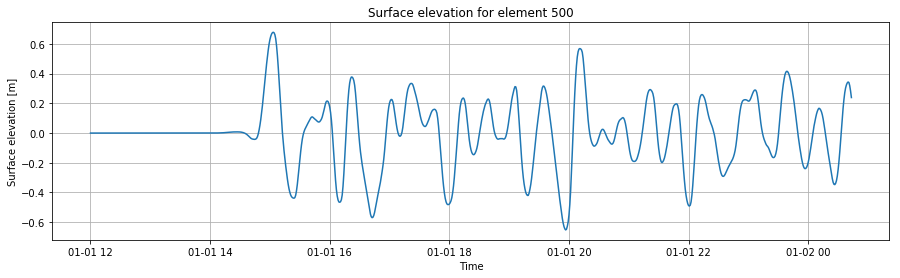

In [40]:
fig, ax = plt.subplots(figsize=(15,4))

ax.plot(area.time, surface_elevation_ele300[0,:])

ax.grid()
ax.set_title("Surface elevation for element 500")
ax.set_ylabel("Surface elevation [m]")
ax.set_xlabel("Time")

plt.show()

## Plot Items

`dfsu` objects support some quick plotting methods, through `plot_item(...)`

Maximum current

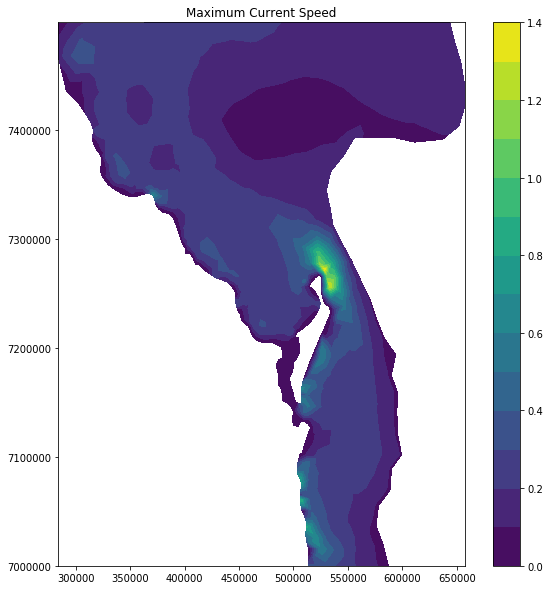

In [13]:
# set timestep to zero since inundation file is an aggregate over the whole model run
# the dfsu file still considers it to have a timestep, but only one, so setting to 0
# will access the first (and only) timestep of the file

plot_dict = dict(levels = np.arange(0,1.5,0.1))

fig_cur, ax_curr, tf_curr = inundation.plot_item(item_name='Maximum current speed', tstep=0,
                                                 kwargs=plot_dict)

fig_cur.set_size_inches(10,10)
ax_curr.set_aspect('equal')

fig_cur.colorbar(tf_curr)

ax_curr.set_title('Maximum Current Speed')
plt.show()

Surface elevation at timstep 500

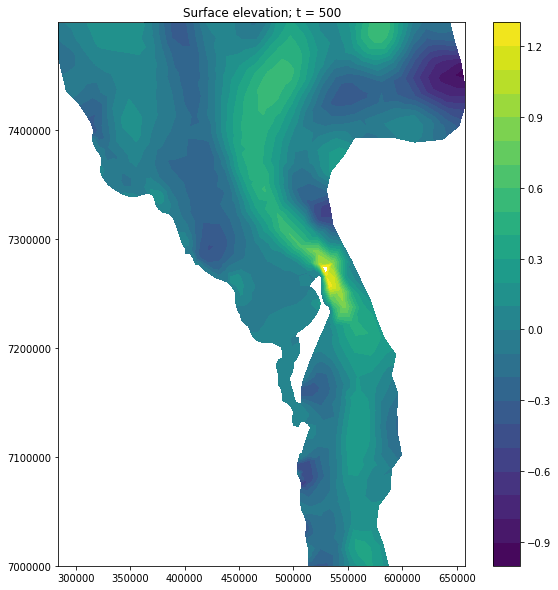

In [14]:
plot_dict = dict(levels = np.arange(-1,1.4,0.1))

fig_se, ax_se, tf_se = area.plot_item(item_name='Surface elevation', tstep=400,
                                                 kwargs=plot_dict)

fig_se.set_size_inches(10,10)
ax_se.set_aspect('equal')

fig_se.colorbar(tf_se)

ax_se.set_title('Surface elevation; t = 500')
plt.show()

## Calculate Max Amplitude

Maximum amplitude can be calculated in two ways:

1. Calculated from maximum water depth in the `inundation` output
2. Calculated from surface elevation over range of timesteps from `area` output

**Method 1**

In [15]:
max_amplitude_1 = inundation.max_ampltiude()

**Method 2**

In [16]:
max_amplitude_2 = area.max_item('Surface elevation', node=True)

Compare methods

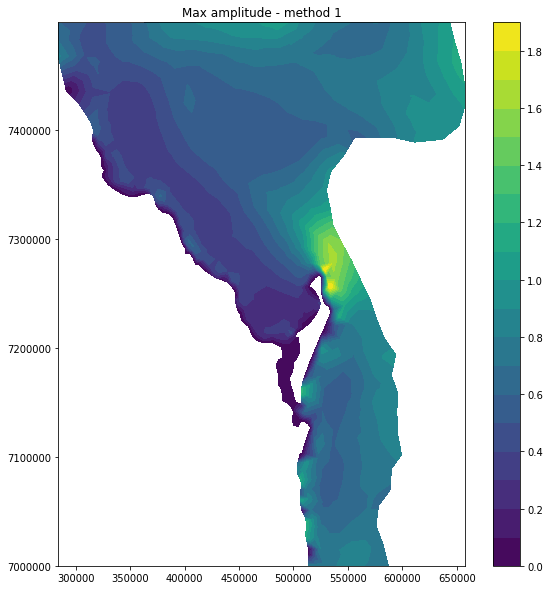

In [17]:
plot_dict = dict(levels = np.arange(0,2,0.1))

fig_ma1, ax_ma1, tf_ma1 = area.plot_item(node_data=max_amplitude_1, kwargs=plot_dict)

fig_ma1.set_size_inches(10,10)
ax_ma1.set_aspect('equal')

fig_ma1.colorbar(tf_ma1)

ax_ma1.set_title('Max amplitude - method 1')
plt.show()

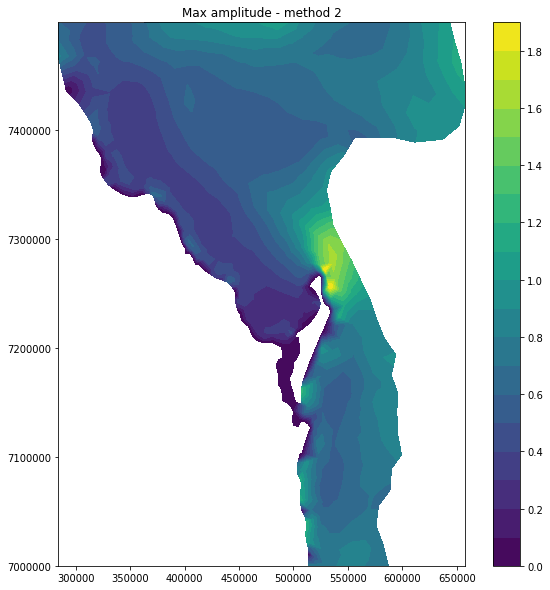

In [18]:
plot_dict = dict(levels = np.arange(0,2,0.1))

figma2, axma2, tfma2 = area.plot_item(node_data=max_amplitude_2, kwargs=plot_dict)

figma2.set_size_inches(10,10)
axma2.set_aspect('equal')

figma2.colorbar(tfma2)

axma2.set_title('Max amplitude - method 2')
plt.show()

We get similar outputs from both methods. Differences can potentially occur by having large timesteps in writing the area output so that some maxima are missed.

All mesh elevation values in the `inundation.dfsu` will be adjusted for any datum shift used in the model. If this is in the case, the `max_amplitude` method accepts a `datum_shift` input to account for this.

## Unstructured Mesh to Regular Grid to Raster

Data at either nodes or elements on an unstructured can be interpolated to a regular grid at whatever desired resolution.

Since the regular grid will create points spanning the entire rectangular domain of the model, we will receive points outside of our model domain. To remove these, we can generate a mask from the `mesh` file used for the model and use this to only select the regular grid points within the model.

Once we have data on a regular grid, exporting to raster using a library such as `GDAL` is straightforward. 

First, we will load the `mesh` file and get the model mask

In [20]:
mesh_f = 'data/example_mesh_no_elevation.mesh'
m = mesh.Mesh(mesh_f)

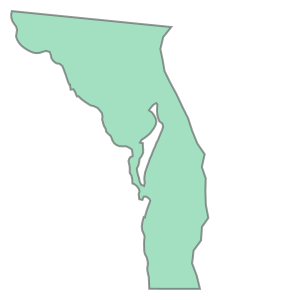

In [21]:
mask = m.mask()
mask

Call `grid_res` for 500 metres and then create boolean mask over the created grid which will return `True` for points that are within model, and `False` otherwise

In [23]:
area.grid_res(res=500)
bm = area.boolean_mask(mask, res=500)

Calling `grid_res` creates the interpolation weights as well as `X` and `Y` grids at that resolution covering the model domain

In [24]:
area.grid_x, area.grid_y

(array([[283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072],
        [283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072],
        [283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072],
        ...,
        [283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072],
        [283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072],
        [283928.30655072, 284428.30655072, 284928.30655072, ...,
         656428.30655072, 656928.30655072, 657428.30655072]]),
 array([[6999849.4398, 6999849.4398, 6999849.4398, ..., 6999849.4398,
         6999849.4398, 6999849.4398],
        [7000349.4398, 7000349.4398, 7000349.4398, ..., 7000349.4398,
         7000349.4398, 7000349.4398],
        [7000



Set the grid resolution using the `dfsu` method `grid_res()`. This will calculate the weights required to interpolate from the unstructured mesh to a regular grid. This is the required initial step and once this is done multiple items of either element or node data is able to be interpollated on without re-calculating the weights. The weights will need to be re-calculated if the grid resolution changes.

Gridded data can be obatined in a few ways:

1. Call method `gridded_item` for specific item, such as surface elevation, for specific time stamp or range of time stamps
2. Call method `gridded_stats` for specific item to get maximum or minimum item value across model run or within range of time stamps
3. Call method `gridded_item` parsing in array for `node_data`, where the node data can be some manipulated data which can be gridded

Will only use method 1 as an example, but each approach is very similar

In [27]:
grid_cs_t500 = area.gridded_item(item_name='Current speed', tstep_start=500, res=500)

C:\ProgramData\Anaconda3\lib\site-packages\dhitools\_gridded_interpolate.py:107: RuntimeWarning: invalid value encountered in less
  interp_z[np.any(weights < 0, axis=1)] = fill_value


Apply mask to gridded data and plot

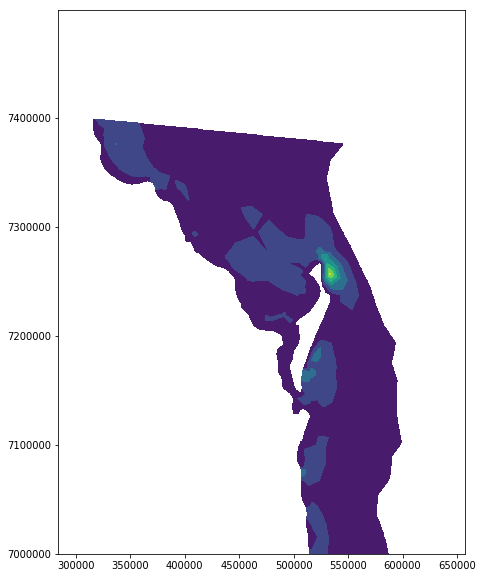

In [36]:
# Apply boolean mask using numpy masked array
grid_cs_t500m = ma.masked_array(grid_cs_t500[0], mask = ~bm, fill_value=np.nan)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

ax.contourf(area.grid_x, area.grid_y, grid_cs_t500m)

plt.show()

Have current speed interpolated to a regular grid with resolution 500m. This could be directly exported to a raster using `GDAL`